In [3]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.1 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import math
from tensorflow.keras.callbacks import Callback, EarlyStopping
import tensorflow_addons as tfa
# 데이터 로딩 및 전처리

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    angle = tf.random.uniform([], -0.2, 0.2)  # 랜덤 각도 생성
    image = tfa.image.rotate(image, angle)
    image = tf.image.random_brightness(image, max_delta=0.2)  # 랜덤 밝기 조절
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)  # 랜덤 대비 조절
    return image, label

def prepare_for_training(ds, shuffle_buffer_size=1000, BATCH_SIZE=32, AUTOTUNE=tf.data.AUTOTUNE):
    ds = ds.map(augment, num_parallel_calls=2)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(32)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# 데이터 파이프라인 준비
train_ds = prepare_for_training(train_ds)

170498071/170498071 [==============================] - 14s 0us/step


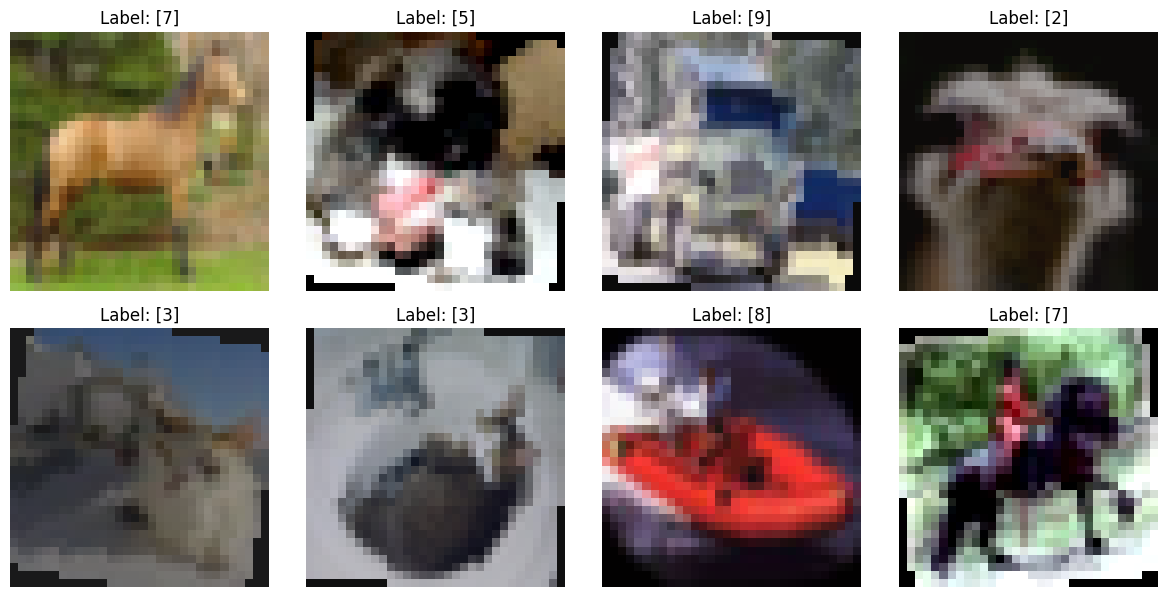

In [7]:
sample_batch = next(iter(train_ds))
augmented_images, augmented_labels = sample_batch
num_images_to_show = 8
plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(augmented_images[i])
    plt.title(f"Label: {augmented_labels[i].numpy()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
# BasicBlock 정의
def BasicBlock(inputs, filters, stride=1):
    shortcut = inputs

    x = Conv2D(filters, (3, 3), strides=stride, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

# ResNet 정의
def ResNet18():
    inputs = Input(shape=(32, 32, 3))

    x = Conv2D(64, (3, 3), strides=1, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = BasicBlock(x, 64)
    x = BasicBlock(x, 64)
    x = BasicBlock(x, 128, stride=2)
    x = BasicBlock(x, 128)
    x = BasicBlock(x, 256, stride=2)
    x = BasicBlock(x, 256)
    x = BasicBlock(x, 512, stride=2)
    x = BasicBlock(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [9]:
model = ResNet18()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]']

In [10]:
# 모델 컴파일
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
# class TestLossCallback(Callback):
#     def __init__(self, test_data, evaluation_interval):
#         super(TestLossCallback, self).__init__()
#         self.test_data = test_data
#         self.evaluation_interval = evaluation_interval
#         self.counter = 0

#     def on_epoch_end(self, epoch, logs=None):
#         self.counter += 1
#         if self.counter % self.evaluation_interval == 0:
#             test_loss, _ = self.model.evaluate(self.test_data[0], self.test_data[1], verbose=0)
#             self.model.test_loss = test_loss  # 모델 객체에 테스트 데이터의 loss 값을 저장
#             self.counter = 0  # 카운터 초기화
# test_loss_callback = TestLossCallback(test_data=(x_test, y_test),evaluation_interval=10)
# early_stopping = EarlyStopping(monitor='test_loss', mode='min', patience=3, restore_best_weights=True)

In [13]:
# 학습 루프
num_epochs = 100

# steps_per_epoch를 설정합니다.
steps_per_epoch = len(x_train) // 32

# 학습을 수행합니다.
history = model.fit(train_ds,
                    epochs=num_epochs,
                    steps_per_epoch=steps_per_epoch)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

Epoch 1/100
1562/1562 [==============================] - 74s 47ms/step - loss: 1.2159 - accuracy: 0.5639
Epoch 2/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.8816 - accuracy: 0.6908
Epoch 3/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.7215 - accuracy: 0.7479
Epoch 4/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.6271 - accuracy: 0.7827
Epoch 5/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.5588 - accuracy: 0.8077
Epoch 6/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.4987 - accuracy: 0.8272
Epoch 7/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.4433 - accuracy: 0.8463
Epoch 8/100
1562/1562 [==============================] - 67s 43ms/step - loss: 0.4054 - accuracy: 0.8586
Epoch 9/100
1562/1562 [==============================] - 66s 42ms/step - loss: 0.3634 - accuracy: 0.8737
Epoch 10/100
1562/1562 [==============================]

In [14]:
test_loss, test_acc = model.evaluate(test_ds.batch(32))
print(f"Test accuracy: {test_acc * 100:.2f}%")

313/313 [==============================] - 4s 12ms/step - loss: 0.5340 - accuracy: 0.9019
Test accuracy: 90.19%


313/313 - 3s - loss: 0.5340 - accuracy: 0.9019 - 3s/epoch - 11ms/step
Test accuracy: 90.19%


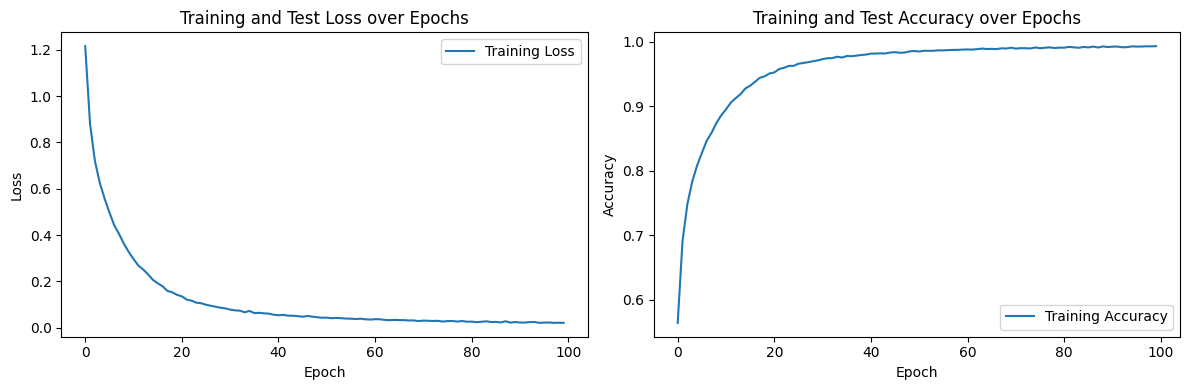

In [15]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")
# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# 훈련 손실 및 테스트 손실 시각화
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
if hasattr(model, 'test_loss'):  # TestLossCallback가 test_loss를 저장한 경우에만 시각화
    plt.plot([i * test_loss_callback.evaluation_interval for i in range(len(history.history["loss"]))],
             [model.test_loss] * len(history.history["loss"]),
             label="Test Loss", linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs")
plt.legend()

# 훈련 정확도 및 테스트 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
if hasattr(model, 'test_loss'):  # TestLossCallback가 test_loss를 저장한 경우에만 시각화
    plt.plot([i * test_loss_callback.evaluation_interval for i in range(len(history.history["accuracy"]))],
             [test_acc] * len(history.history["accuracy"]),
             label="Test Accuracy", linestyle='dashed')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Test Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

313/313 [==============================] - 3s 10ms/step


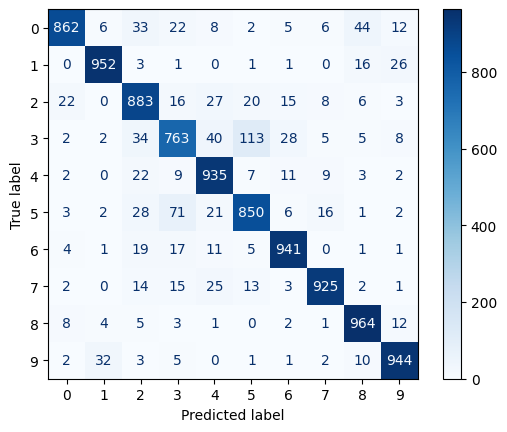

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes using the trained model
predicted_probs = model.predict(x_test)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Create the confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

# Display the confusion matrix
classes = [str(i) for i in range(10)]  # Assuming you have 10 classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues, values_format=".0f")
plt.show()

1/1 [==============================] - 1s 678ms/step


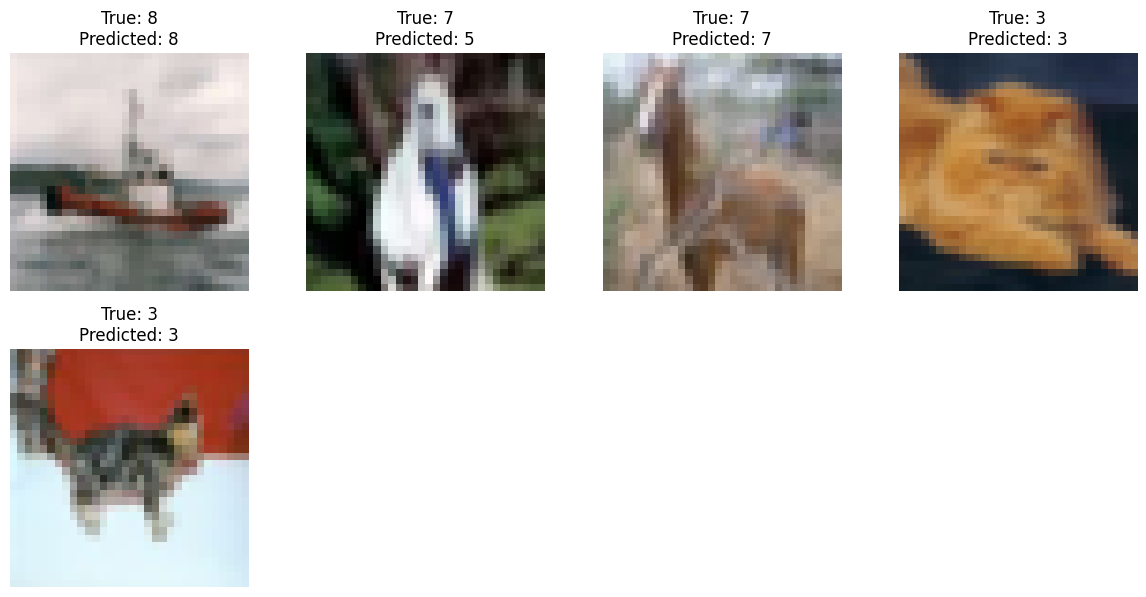

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Get some data to visualize
num_images_to_visualize = 5  # 변경된 부분: 8 -> 5
sample_indices = np.random.randint(0, len(x_test), num_images_to_visualize)
sample_images = x_test[sample_indices]
sample_labels = y_test[sample_indices]

# Predict classes using the trained model
predicted_probs = model.predict(sample_images)
predicted_classes = np.argmax(predicted_probs, axis=1)

# Visualize the predicted results
plt.figure(figsize=(12, 12))
for i in range(num_images_to_visualize):
    plt.subplot(4, 4, i+1)  # 변경된 부분: 4, 4 -> 5, 1
    plt.imshow(sample_images[i])
    plt.title(f"True: {sample_labels[i][0]}\nPredicted: {predicted_classes[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()